# GenCode Explore

Explore the human RNA sequences from GenCode.

Assume user downloaded files from GenCode 38 [FTP](http://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_38/)
to a subdirectory called data.

Improve on GenCode_Explore_101.ipynb

Use ORF_counter. 

Use MatPlotLib to make box plots and heat maps.

In [1]:
import time 
def show_time():
    t = time.time()
    s = time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))
    print(s)
show_time()

2021-06-11 18:09:36 UTC


In [2]:
import numpy as np
import pandas as pd
import gzip
import sys
try:
    from google.colab import drive
    IN_COLAB = True
    print("On Google CoLab, mount cloud-local file, get our code from GitHub.")
    PATH='/content/drive/'
    #drive.mount(PATH,force_remount=True)  # hardly ever need this
    drive.mount(PATH)    # Google will require login credentials
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    import requests
    s = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_describe.py')
    with open('RNA_describe.py', 'w') as f:
      f.write(s.text)  # writes to cloud local, delete the file later?
    s = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/GenCodeTools.py')
    with open ('GenCodeTools.py', 'w') as f:
      f.write(s.text)
    s = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/plot_generator.py')
    with open('plot_generator.py', 'w') as f:
      f.write(s.text)
    s = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_gen.py')
    with open('RNA_gen.py', 'w') as f:
      f.write(s.text)
    from RNA_describe import *
    from GenCodeTools import *
    from plot_generator import *
    from RNA_gen import *
except:
    print("CoLab not working. On my PC, use relative paths.")
    IN_COLAB = False
    DATAPATH='../data/'  # must end in "/"
    sys.path.append("..") # append parent dir in order to use sibling dirs
    from SimTools.RNA_describe import *
    from SimTools.GenCodeTools import *
    from SimTools.plot_generator import *
    from SimTools.RNA_gen import *

MODELPATH="BestModel"  # saved on cloud instance and lost after logout
#MODELPATH=DATAPATH+MODELPATH  # saved on Google Drive but requires login

if not assert_imported_RNA_describe():
    print("ERROR: Cannot use RNA_describe.")

On Google CoLab, mount cloud-local file, get our code from GitHub.
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
PC_FILENAME='gencode.v38.pc_transcripts.fa.gz'
NC_FILENAME='gencode.v38.lncRNA_transcripts.fa.gz'

## Load the GenCode data.
Warning: GenCode has
over 100K protein-coding RNA (mRNA) 
and almost 50K non-coding RNA (lncRNA).

In [4]:
# Full GenCode ver 38 human is 106143 pc + 48752 nc and loads in 7 sec.
# Expect fewer transcripts if special filtering is used.
PC_FULLPATH=DATAPATH+PC_FILENAME
NC_FULLPATH=DATAPATH+NC_FILENAME
loader=GenCodeLoader()
show_time()
loader.set_label(1)
loader.set_check_list(None) 
loader.set_check_utr(True)
pcdf=loader.load_file(PC_FULLPATH)
print("PC seqs loaded:",len(pcdf))
show_time()
loader.set_label(0)
loader.set_check_list(None)
loader.set_check_utr(False)
ncdf=loader.load_file(NC_FULLPATH)
print("NC seqs loaded:",len(ncdf))
show_time()

2021-06-11 18:09:36 UTC
PC seqs loaded: 70825
2021-06-11 18:09:41 UTC
NC seqs loaded: 48752
2021-06-11 18:09:43 UTC


In [5]:
#TODO: reduce data set size (just take a sampling?)
print("Sorting PC...")
pcdf.sort_values('seqlen', ascending=True, inplace=True)
print("Sorting NC...")
ncdf.sort_values('seqlen', ascending=True, inplace=True)
show_time()

Sorting PC...
Sorting NC...
2021-06-11 18:09:43 UTC


In [6]:
# This is a fast way to slice if you have length thresholds.
# TO DO: choose length thresholds and apply to PC and NC RNA.
# For example: 200, 400, 800, 1600, 3200, 6400 (e.g. 200-399, etc.)
#mask = (ncdf['sequence'].str.len() < 1000)
#subset = ncdf.loc[mask]

###Bin sequences by length

---

In [7]:
def subset_list_by_len_bounds(input_list, min_len, max_len):
  return list(filter(lambda x: len(x) > min_len and len(x) < max_len, input_list))

In [8]:
bins = [(200, 400), (400, 800), (800, 1600), (1600, 3200), (3200, 6400), (6400, 12800), (12800, 25600), (25600, 51200)]
NUM_BINS = len(bins)

Generate simulated non-random codon selection based RNA sequences

In [9]:
#TODO: optimize
simulator = Collection_Generator()
#simulator.set_reproducible(True) #Not sure if good to do or bad in this case
sim_sequences = []
for bin in bins:
  seq_len = (bin[0] + bin[1]) // 2 #Fits the sequences to the bins which could be misleading
  simulator.get_len_oracle().set_mean(seq_len)
  #TODO: set standard deviation
  #Use default simulator sequence and frequency settings
  seq_cnt = (len(pcdf) + len(ncdf)) // 2 // NUM_BINS #Guarantees same number of sequences for each bin
  #leave data set pre-binned
  seq_set = simulator.get_sequences(seq_cnt)
  for seq in seq_set:
    sim_sequences.append(seq)
show_time()

2021-06-11 18:13:27 UTC


In [10]:
#Bin the RNA sequences
binned_pc_sequences = []
binned_nc_sequences = []
binned_sim_sequences = []
for i in range(0, NUM_BINS):
  bin = bins[i]
  binned_pc_sequences.append([])
  binned_nc_sequences.append([])
  binned_sim_sequences.append([])
  binned_pc_sequences[i] = subset_list_by_len_bounds(pcdf['sequence'].tolist(), bin[0], bin[1])
  binned_nc_sequences[i] = subset_list_by_len_bounds(ncdf['sequence'].tolist(), bin[0], bin[1])
  binned_sim_sequences[i] = subset_list_by_len_bounds(sim_sequences, bin[0], bin[1])
show_time()

2021-06-11 18:13:28 UTC


##Gather data on ORF lengths and the number of contained and non-contained ORFs

---

In [11]:
#TODO: optimize. combine data?
pc_max_len_data = np.empty(NUM_BINS, dtype=object)
pc_max_cnt_data = np.empty(NUM_BINS, dtype=object)
pc_contain_data = np.empty(NUM_BINS, dtype=object)
nc_max_len_data = np.empty(NUM_BINS, dtype=object)
nc_max_cnt_data = np.empty(NUM_BINS, dtype=object)
nc_contain_data = np.empty(NUM_BINS, dtype=object)
sim_max_len_data = np.empty(NUM_BINS, dtype=object)
sim_max_cnt_data = np.empty(NUM_BINS, dtype=object)
sim_contain_data = np.empty(NUM_BINS, dtype=object)

oc = ORF_counter()

for bin in range(0, NUM_BINS):
  pc_max_len_data[bin] = np.zeros(len(binned_pc_sequences[bin]))
  pc_max_cnt_data[bin] = np.zeros(len(binned_pc_sequences[bin]))
  pc_contain_data[bin] = np.zeros(len(binned_pc_sequences[bin]))
  nc_max_len_data[bin] = np.zeros(len(binned_nc_sequences[bin]))
  nc_max_cnt_data[bin] = np.zeros(len(binned_nc_sequences[bin]))
  nc_contain_data[bin] = np.zeros(len(binned_nc_sequences[bin]))
  sim_max_len_data[bin] = np.zeros(len(binned_sim_sequences[bin]))
  sim_max_cnt_data[bin] = np.zeros(len(binned_sim_sequences[bin]))
  sim_contain_data[bin] = np.zeros(len(binned_sim_sequences[bin]))
  #Gather protein-coding sequence data
  for seq in range(0, len(binned_pc_sequences[bin])):
    oc.set_sequence(binned_pc_sequences[bin][seq])
    pc_max_len_data[bin][seq] = oc.get_max_orf_len()
    pc_max_cnt_data[bin][seq] = oc.count_maximal_orfs()
    pc_contain_data[bin][seq] = oc.count_contained_orfs()

  #Gather non-coding sequence data
  for seq in range(0, len(binned_nc_sequences[bin])):
    oc.set_sequence(binned_nc_sequences[bin][seq])
    nc_max_len_data[bin][seq] = oc.get_max_orf_len()
    nc_max_cnt_data[bin][seq] = oc.count_maximal_orfs()
    nc_contain_data[bin][seq] = oc.count_contained_orfs()

  #Gather simulated sequence data
  for seq in range(0, len(binned_sim_sequences[bin])):
    oc.set_sequence(binned_sim_sequences[bin][seq])
    sim_max_len_data[bin][seq] = oc.get_max_orf_len()
    sim_max_cnt_data[bin][seq] = oc.count_maximal_orfs()
    sim_contain_data[bin][seq] = oc.count_contained_orfs()
show_time()

2021-06-11 18:17:29 UTC


##Prepare data for heatmap

---

In [12]:
#TODO: replace with numpy functionality
def mean(data):
  if len(data) == 0:
    return 0
  return sum(data) / len(data)

In [13]:
#Get the means of all of the data
mean_pc_max_len_data = np.zeros(NUM_BINS)
mean_pc_max_cnt_data = np.zeros(NUM_BINS)
mean_pc_contain_data = np.zeros(NUM_BINS)
mean_nc_max_len_data = np.zeros(NUM_BINS)
mean_nc_max_cnt_data = np.zeros(NUM_BINS)
mean_nc_contain_data = np.zeros(NUM_BINS)
mean_sim_max_len_data = np.zeros(NUM_BINS)
mean_sim_max_cnt_data = np.zeros(NUM_BINS)
mean_sim_contain_data = np.zeros(NUM_BINS)
for i in range(0, NUM_BINS):
  mean_pc_max_len_data[i] = mean(pc_max_len_data[i])
  mean_pc_max_cnt_data[i] = mean(pc_max_cnt_data[i])
  mean_pc_contain_data[i] = mean(pc_contain_data[i])
  mean_nc_max_len_data[i] = mean(nc_max_len_data[i])
  mean_nc_max_cnt_data[i] = mean(nc_max_cnt_data[i])
  mean_nc_contain_data[i] = mean(nc_contain_data[i])
  mean_sim_max_len_data[i] = mean(sim_max_len_data[i])
  mean_sim_max_cnt_data[i] = mean(sim_max_cnt_data[i])
  mean_sim_contain_data[i] = mean(sim_contain_data[i])
show_time()

2021-06-11 18:17:29 UTC


###Prepare data for plot of bin sizes

---

In [14]:
pc_bin_sizes = np.zeros(NUM_BINS)
nc_bin_sizes = np.zeros(NUM_BINS)
sim_bin_sizes = np.zeros(NUM_BINS)
for i in range(0, NUM_BINS):
  pc_bin_sizes[i] = len(binned_pc_sequences[i])
  nc_bin_sizes[i] = len(binned_nc_sequences[i])
  sim_bin_sizes[i] = len(binned_sim_sequences[i])
show_time()

2021-06-11 18:17:29 UTC


###Prepare data for plot of number of sequences with no ORFs and plot of number of sequences with max ORF lengths equal to or less than 100

---

In [15]:
"""
Counts the number of RNA sequences that fit the given constraints.
Sequence range constraints are exclusive.
Max ORF length constraints are inclusive.
DEPRECATED
"""
def count_constraint_valid_sequences(data, min_seq_len, max_seq_len, min_max_orf_len, max_max_orf_len):
  count = 0
  oc = ORF_counter()
  if isinstance(data, list):
    sequences = data
  else: #Therefore is pandas dataframe
    sequences = data['sequence'].tolist()
  for seq in sequences:
    seq_len = len(seq)
    if seq_len > min_seq_len and seq_len < max_seq_len:
      oc.set_sequence(seq)
      max_orf_len = oc.get_max_orf_len()
      if max_orf_len >= min_max_orf_len and max_orf_len <= max_max_orf_len:
        count += 1
  return count


In [16]:
"""
Range inclusive
"""
def count_data_in_range(data, min, max):
  count = 0
  for num in data:
    if num >= min and num <= max:
      count += 1
  return count

In [17]:
pc_no_orf_count = np.zeros(NUM_BINS)
nc_no_orf_count = np.zeros(NUM_BINS)
sim_no_orf_count = np.zeros(NUM_BINS)
pc_max_orf_len_less_than_100 = np.zeros(NUM_BINS)
nc_max_orf_len_less_than_100 = np.zeros(NUM_BINS)
sim_max_orf_len_less_than_100 = np.zeros(NUM_BINS)
for i in range(0, NUM_BINS):
  pc_no_orf_count[i] = count_data_in_range(pc_max_len_data[i], 0, 0)
  nc_no_orf_count[i] = count_data_in_range(nc_max_len_data[i], 0, 0)
  sim_no_orf_count[i] = count_data_in_range(sim_max_len_data[i], 0, 0)
  pc_max_orf_len_less_than_100[i] = count_data_in_range(pc_max_len_data[i], 0, 100)
  nc_max_orf_len_less_than_100[i] = count_data_in_range(nc_max_len_data[i], 0, 100)
  sim_max_orf_len_less_than_100[i] = count_data_in_range(sim_max_len_data[i], 0, 100)

show_time()

2021-06-11 18:17:29 UTC


## Plot the data

---

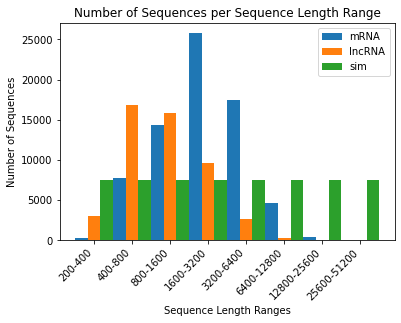

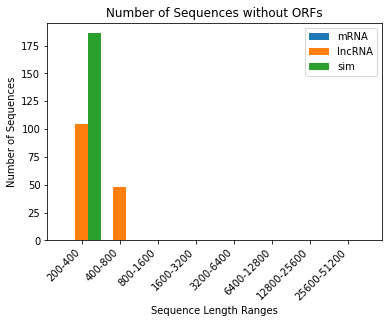

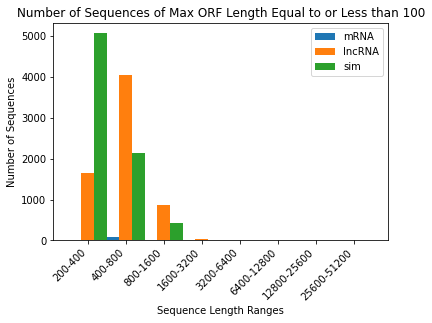

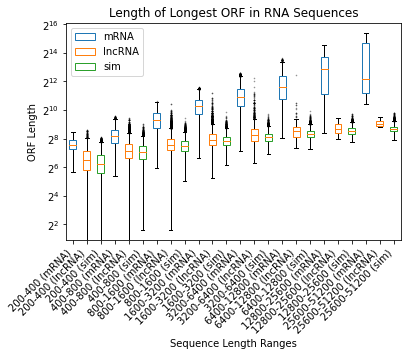

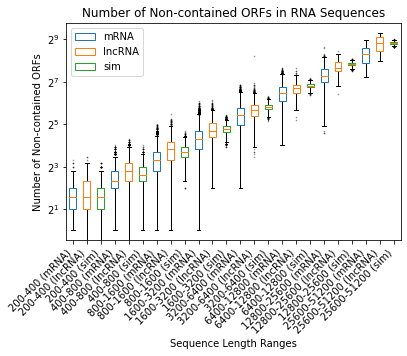

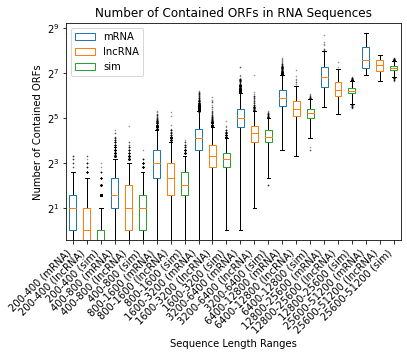

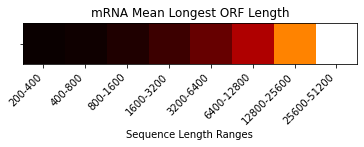

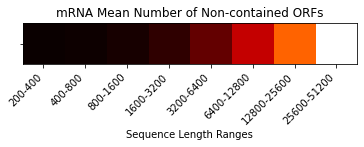

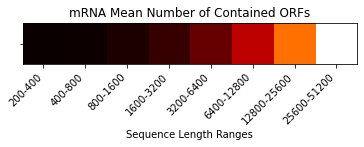

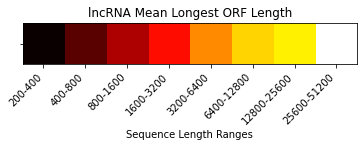

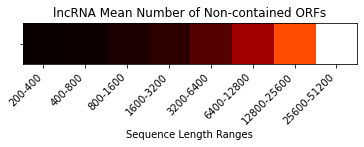

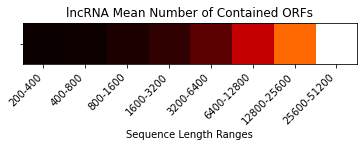

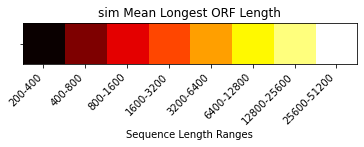

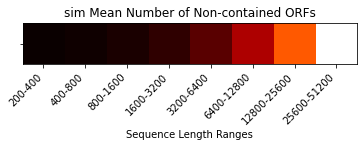

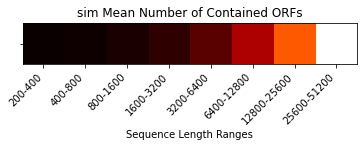

In [18]:
#Generate x-axis labels
x_axis_labels = []
for bin in bins:
  x_axis_labels.append(str(bin[0]) + "-" + str(bin[1]))

data_set_names = ['mRNA', 'lncRNA', 'sim']

#Set up plot generator
pg = PlotGenerator()
pg.set_text_options(45, 'right', 0, 'center')

#Bar plots
pg.set_text('Number of Sequences per Sequence Length Range', 'Sequence Length Ranges', 'Number of Sequences', x_axis_labels, None)
pg.bar_plot([pc_bin_sizes, nc_bin_sizes, sim_bin_sizes], data_set_names)

pg.set_text('Number of Sequences without ORFs', 'Sequence Length Ranges', 'Number of Sequences', x_axis_labels, None)
pg.bar_plot([pc_no_orf_count, nc_no_orf_count, sim_no_orf_count], data_set_names)

pg.set_text('Number of Sequences of Max ORF Length Equal to or Less than 100', 'Sequence Length Ranges', 'Number of Sequences', x_axis_labels, None)
pg.bar_plot([pc_max_orf_len_less_than_100, nc_max_orf_len_less_than_100, sim_max_orf_len_less_than_100], data_set_names)

#Box plots
pg.set_axis_options('linear', 10, 'log', 2)

pg.set_text('Length of Longest ORF in RNA Sequences', 'Sequence Length Ranges', 'ORF Length', x_axis_labels, None)
pg.box_plot([pc_max_len_data, nc_max_len_data, sim_max_len_data], data_set_names, True)

pg.set_text('Number of Non-contained ORFs in RNA Sequences', 'Sequence Length Ranges', 'Number of Non-contained ORFs', x_axis_labels, None)
pg.box_plot([pc_max_cnt_data, nc_max_cnt_data, sim_max_cnt_data], data_set_names, True)

pg.set_text('Number of Contained ORFs in RNA Sequences', 'Sequence Length Ranges', 'Number of Contained ORFs', x_axis_labels, None)
pg.box_plot([pc_contain_data, nc_contain_data, sim_contain_data], data_set_names, True)

#Heatmaps
pg.set_axis_options('linear', 10, 'linear', 10)

pg.set_text('mRNA Mean Longest ORF Length', 'Sequence Length Ranges', '', x_axis_labels, [''])
pg.heatmap([mean_pc_max_len_data])

pg.set_text('mRNA Mean Number of Non-contained ORFs', 'Sequence Length Ranges', '', x_axis_labels, [''])
pg.heatmap([mean_pc_max_cnt_data])

pg.set_text('mRNA Mean Number of Contained ORFs', 'Sequence Length Ranges', '', x_axis_labels, [''])
pg.heatmap([mean_pc_contain_data])

pg.set_text('lncRNA Mean Longest ORF Length', 'Sequence Length Ranges', '', x_axis_labels, [''])
pg.heatmap([mean_nc_max_len_data])

pg.set_text('lncRNA Mean Number of Non-contained ORFs', 'Sequence Length Ranges', '', x_axis_labels, [''])
pg.heatmap([mean_nc_max_cnt_data])

pg.set_text('lncRNA Mean Number of Contained ORFs', 'Sequence Length Ranges', '', x_axis_labels, [''])
pg.heatmap([mean_nc_contain_data])

pg.set_text('sim Mean Longest ORF Length', 'Sequence Length Ranges', '', x_axis_labels, [''])
pg.heatmap([mean_sim_max_len_data])

pg.set_text('sim Mean Number of Non-contained ORFs', 'Sequence Length Ranges', '', x_axis_labels, [''])
pg.heatmap([mean_sim_max_cnt_data])

pg.set_text('sim Mean Number of Contained ORFs', 'Sequence Length Ranges', '', x_axis_labels, [''])
pg.heatmap([mean_sim_contain_data])

## Plotting examples
[boxplot doc](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.boxplot.html)  
[boxplot demo](https://matplotlib.org/stable/gallery/pyplots/boxplot_demo_pyplot.html)  
[heatmap examples](https://stackoverflow.com/questions/33282368/plotting-a-2d-heatmap-with-matplotlib) - scroll down!  